# Building a yield curve using US Treasury T-bill data

In the *Intro to quandl and iexfinance* notebook, we learned how to pull US Treasury data from the US Federal Reserve bank site. We are going to pull prices for T-bills out to 52 weeks maturity, and use that data to build functions that can price a zero coupon with any maturity less than a year.

Here we copy some useful bits of that notebook, and tweak the plot function to plot interest rates.

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import quandl

quandl.ApiConfig.api_key = 'FA6wt7Na6c5FdbqM96i4'

def plot_interest_rates_pp(time_series):
    fig, (histo, qq) = plt.subplots(1, 2, figsize=(12, 4))
    histo.hist(time_series, bins = 20)
    histo.set_title('Distribution of rates')
    histo.set_xlabel('rate')
    histo.set_ylabel('frequency')
    stats.probplot(time_series, dist='norm', plot=plt)
    plt.show()

['4 Wk Bank Discount Rate', '4 Wk Coupon Equiv', '8 Wk Bank Discount Rate', '8 Wk Coupon Equiv', '13 Wk Bank Discount Rate', '13 Wk Coupon Equiv', '26 Wk Bank Discount Rate', '26 Wk Coupon Equiv', '52 Wk Bank Discount Rate', '52 Wk Coupon Equiv']


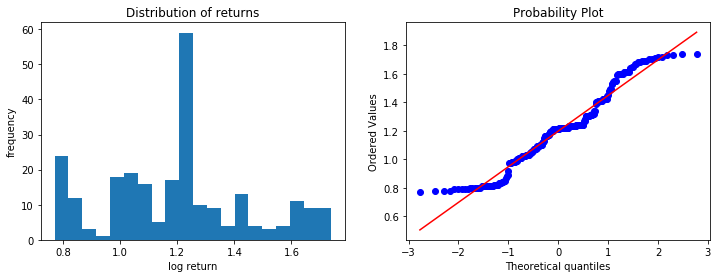

In [132]:
# get quandl 2017 data from USTREASURY/BILLRATES

ust_df = quandl.get('USTREASURY/BILLRATES', start_date='2017-01-01', end_date='2017-12-31')
# Print a list of columns. Which columns do we want?
print(list(ust_df))

# Drop the columns we don't want
for col in list(ust_df):
    if (col.find('Coupon Equiv') == -1):
        ust_df.drop([col], axis=1, inplace=True)
ust_df.drop(['8 Wk Coupon Equiv'], axis=1, inplace=True)
        
# Plot the one year series to visually check for any data anomalies. Make corrections.
one_year_ust_series = ust_df['52 Wk Coupon Equiv']
one_year_ust_series = one_year_ust_series[one_year_ust_series > 0]

plot_hist_pp(one_year_ust_series)

We would like some longer maturity data, but we can attend to that later. We have enough data to start modeling. Treasury bills have no coupon. The purchase price is a percentage of face value. The coupon equivalent represents the annual yield the holder earns. The price $p$ and coupon equivalent $c$ [are related as follows](https://www.investopedia.com/terms/c/couponequivalentrate.asp):

$ c = \frac{1-p}{p} \frac{y}{m} $

where $y$ is the number of days in the year ([365 or 366](https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=billrates)), and $m$ is the number of days to maturity. We want to convert the coupon yield to a continuously compounded rate $r$, which we can get from the price. So we solve for $p$:

$ p = \frac{1}{1 - c \frac{m}{365}}$

Since $p=e^{-rt}$, and $t = \frac{m}{y}$, we have $r = -\frac{\ln p}{m/y}$.

In [133]:
def price(coupon_equiv, maturity):
    return 1 / (1.0 + coupon_equiv * maturity / 365)

print(price(0.022, 28))

0.9983151722025295


In [46]:
import math
def rate(price, maturity):
    return -math.log(price) / (maturity / 365)

print(rate(price(0.022, 28), 28))

0.021981456477085673


Buying a holding a note to maturity is equivalent to constantly investing at the instantaneous forward rate. So $rt = \int_0^t f(s) ds$. Of course, we can't observe $f(t)$. But if we assume that it is piecewise flat, then we can determine $f(t)$ for all $t$ up to the maximum maturity of our zeroes. 

Let $t_0=0$, and let $t_1 < ... < t_n$ be the maturities of the zeroes. Define $f_i$ to be the instantaneous forward rate on $(t_{i-1}, t_i]$.

If we define $r_i$ to be the continuously compounded rate to time $t_i$, then $r_i t_i =r_{i-1}t_{i-1} + f_i(t_i-t_{i-1})$. Hence $f_i = \frac{r_i t_i - r_{i-1}t_{i-1}}{t_i-t_{i-1}}$.

To model this, we create a term structure object.

In [135]:
class RateTermStructure:
    def __init__(self, maturity_list, zero_rate_list):
        self.times_in_years = list(maturity_list)
        self.zero_rates = list(zero_rate_list)
        self.forward_rates = []
        r_previous = 0
        t_previous = 0
        for t, r in zip(self.times_in_years, self.zero_rates):
            self.forward_rates.append((r * t - r_previous * t_previous) / (t - t_previous))
            r_previous = r
            t_previous = t
            
    def format_rate(self, x):
        return '{:{width}.{prec}f}'.format(x, width=6, prec=4)
            

    def format_time(self, x):
        return '{:{width}.{prec}f}'.format(x, width=5, prec=2)
    
    def forward_rate_cc(self, years):
        for t, r in zip(self.times_in_years, self.forward_rates):
            if t > years:
                return r
        return float('nan')     

    
    def zero_rate_cc(self, years):
        if years == 0:
            return self.forward_rates[0]
        # accumulate rate
        rate = 0
        t_previous = 0
        for t, r in zip(self.times_in_years, self.forward_rates):
            if t < years:
                rate += r * (t - t_previous)
            else:
                return (rate + r * (years - t_previous)) / years
            t_previous = t
        return float('nan')     


    def __repr__(self):
        return str([self.format_time(t)+'->'+self.format_rate(f) for t, f in zip(self.times_in_years,self.forward_rates )])
            
times = [(7 * wk) / 365.0 for wk in [4, 13, 26, 52]]
# pick a date for testing purposes
print(times)
date = ust_df.index[0]
zero_rates = [0.01 * (ust_df[col])[date] for col in list(ust_df)]
print(zero_rates)
rts = RateTermStructure(times, zero_rates)
print(rts)
rts.forward_rate_cc(0.49)

[0.07671232876712329, 0.2493150684931507, 0.4986301369863014, 0.9972602739726028]
[0.005200000000000001, 0.0054, 0.006500000000000001, 0.0089]
[' 0.08->0.0052', ' 0.25->0.0055', ' 0.50->0.0076', ' 1.00->0.0113']


0.007600000000000001

Let's graph the instantaneous forward and zero curves.

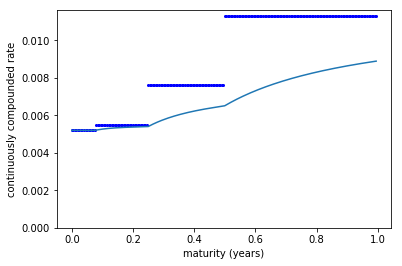

In [136]:
import matplotlib.pyplot as plt

times = np.arange(0, 1, 0.005)
ffr = [rts.forward_rate_cc(t) for t in times]
zero_rates = [rts.zero_rate_cc(t) for t in times]

plt.plot(times, ffr, 'bo', markersize = 2)
plt.plot(times, zero_rates)
plt.ylim(bottom=0)
plt.xlabel('maturity (years)')
plt.ylabel('continuously compounded rate')
# plt.axis([0, 6, 0, 20])
plt.show()